Imports: 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext
import time
import random
import torch.optim as optim
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader, TensorDataset
import nltk
import os

!pip install -U spacy


# Switch PyTorch to GPU compute
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device=torch.device("cpu")
print("We're using:", device)

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
We're using: cuda


Settings 

In [2]:
RANDOM_SEED = 123
torch.manual_seed(RANDOM_SEED)

VOCABULARY_SIZE = 20000
LEARNING_RATE = .005  
BATCH_SIZE = 128
NUM_EPOCHS = 15

EMBEDDING_DIM = 128
HIDDEN_DIM = 256
NUM_CLASSES = 2

For the data, you can click download at
https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews

You can choose to store the data in your google drive and mount your drive for accessing them from the following cell.

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

Or you can download it by the following cell:

In [4]:
!pip install --upgrade --no-cache-dir gdown
if not os.path.exists("Reviews.csv"):
    !gdown 1_kLSwiRYtiXF7h9V1FlTqTapOHiYU5Mk

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [5]:
# Remeber to change the path here for the corresponding files you need
df = pd.read_csv('Reviews.csv')
print(df.shape)

entries = 29000

df5 = df[df["Score"] == 5]
df5 = df5.head(entries)
df4 = df[df["Score"] == 4]
df4 = df4.head(entries)
df3 = df[df["Score"] == 3]
df3 = df3.head(entries)
df2 = df[df["Score"] == 2]
df2 = df2.head(entries)
df1 = df[df["Score"] == 1]
df1 = df1.head(entries)

df = pd.concat([df1, df2, df3, df4, df5])

print(df.shape)


df = df[['Score', 'Text']]
df.columns = ['Labels', 'Reviews']

df.to_csv('review_data.csv', index=None)

df = pd.read_csv('review_data.csv')
df.head()



reviews = df['Reviews']
labels = df['Labels']

print(reviews)
print(labels)


(568454, 10)
(145000, 10)
0         Product arrived labeled as Jumbo Salted Peanut...
1         My cats have been happily eating Felidae Plati...
2         The candy is just red , No flavor . Just  plan...
3         This oatmeal is not good. Its mushy, soft, I d...
4         Arrived in 6 days and were so stale i could no...
                                ...                        
144995    Just add water and Shazaam it's Peanut Butter ...
144996    This is by far the best choice for a low fat o...
144997    Peanut butter was one of the things I reluctan...
144998    i'm watching my calorie intake - and after rea...
144999    I love PB2 - I add it to chocolate protein smo...
Name: Reviews, Length: 145000, dtype: object
0         1
1         1
2         1
3         1
4         1
         ..
144995    5
144996    5
144997    5
144998    5
144999    5
Name: Labels, Length: 145000, dtype: int64


In [6]:
# import libraries for preprocessing
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import MultiLabelBinarizer
from string import punctuation
from string import digits
from collections import Counter
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [31]:
# function to remove stop words
eng_stopwords = stopwords.words('english') 
def filter_words(alist):
  ret_l = []
  for w in alist:
    for el in w:
        if el in punctuation:
          w = w.replace(el,"")
    if w.lower() not in eng_stopwords and w not in punctuation and w != '...' and w !='br' and w not in digits and w != 'nt':
      ret_l.append(w.lower())
  return ret_l

In [7]:
# preprocess the data

# below 2 is 0 (negative) 3 and above is positive
# labels = np.rint(labels / 5)

all_reviews=list()
for text in reviews:
  text = text.lower()
  text = "".join([ch for ch in text if ch not in punctuation])
  all_reviews.append(text)
all_text = " ".join(all_reviews)
all_words = all_text.split()

In [8]:
from collections import Counter 
# Count all the words using Counter Method
count_words = Counter(all_words)
total_words=len(all_words)
sorted_words=count_words.most_common(total_words)
print(sorted_words[:10])

[('the', 561378), ('i', 429229), ('a', 332025), ('and', 327629), ('to', 284875), ('it', 261597), ('of', 234053), ('is', 195099), ('this', 185538), ('in', 148103)]


In [9]:
vocab_to_int={w:i+1 for i,(w,c) in enumerate(sorted_words)}
# print(vocab_to_int)


In [10]:
# transform reviews into lists of numbers
e_rev = []
for review in all_reviews:
  e = []
  for word in review:
    if word not in vocab_to_int.keys():
      e.append(0)
    else:
      e.append(vocab_to_int[word])
  e_rev.append(e)

In [11]:
# make the feature array and make the inputs all the same length
length = 300
feats=np.zeros((len(e_rev), length), dtype=int)

for i, rev in enumerate(e_rev):
  if len(rev) > length:
    feats[i,:] = np.array(rev[:length])
  else:
    for j in range(len(rev)):
      feats[i,j] = rev[j]

In [12]:
# transform into tensor for pytorch
data = np.column_stack((feats, labels))
data = data.astype(float)
transform = transforms.Compose([transforms.ToTensor()])

data = transform(data)
data = torch.squeeze(data, dim=0)

In [13]:
# Train/Validation/Test split

from sklearn.model_selection import train_test_split

feats = data[:, :-1]
labels = data[:, -1]
labels = F.one_hot(labels.to(torch.int64), num_classes=6)
labels = labels[:, 1:]

print(feats.shape)

train_x, test_x, train_y, test_y = train_test_split(feats, labels, test_size=0.20, random_state=42, shuffle=True)
valid_x, test_x, valid_y, test_y = train_test_split(test_x, test_y, test_size=0.50, random_state=42, shuffle=True)


# train_x=feats[:int(0.8*len(feats))]
# train_y=labels[:int(0.8*len(feats))]
# valid_x=feats[int(0.8*len(feats)):int(0.9*len(feats))]
# valid_y=labels[int(0.8*len(feats)):int(0.9*len(feats))]
# test_x=feats[int(0.9*len(feats)):]
# test_y=labels[int(0.9*len(feats)):]



print(train_x.shape, valid_y.shape, test_x.shape)

torch.Size([145000, 300])
torch.Size([116000, 300]) torch.Size([14500, 5]) torch.Size([14500, 300])


In [14]:
train_dataset = TensorDataset(torch.LongTensor(train_x.numpy()), torch.LongTensor(train_y.numpy()))
valid_dataset = TensorDataset(torch.tensor(valid_x), torch.tensor(valid_y))
test_dataset = TensorDataset(torch.LongTensor(test_x.numpy()), torch.LongTensor(test_y.numpy()))

batch_size = 500

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


/tmp/ipykernel_32676/3758567898.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  valid_dataset = TensorDataset(torch.tensor(valid_x), torch.tensor(valid_y))


In [48]:
#Recurrent Neural Network class
import torch.nn as nn

class RNN(nn.Module):
  def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob):
    super().__init__()
    self.output_size=output_size
    self.n_layers=n_layers
    self.hidden_dim=hidden_dim
    
    #Embedding and LSTM layers
    self.embedding=nn.Embedding(vocab_size, embedding_dim)
    self.lstm=nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
    
    #dropout layer
    self.dropout=nn.Dropout(0.5)
    
    #Linear and sigmoid layer
    self.fc1=nn.Linear(hidden_dim, 1024)
    self.fc2=nn.Linear(1024, 256)
    self.fc3=nn.Linear(256,128)
    self.fc4=nn.Linear(128,64)
    self.fc5=nn.Linear(64,16)
    self.fc6=nn.Linear(16 ,output_size)
    self.sigmoid=nn.Sigmoid() # for binary
    self.relu = nn.ReLU()     # for multi-class

    
  def forward(self, x, hidden):
      """
      Perform a forward pass of our model on some input and hidden state.
      """

      batch_size = x.size()[0]
      
      #Embadding and LSTM output
      x = x.long()

      embedd=self.embedding(x)
      # x = torch.transpose(embedd, 2, 1)
      # print(embedd.size())

      # embedd = torch.transpose(embedd, 2, 1)
      
      # print(embedd.size())
      lstm_out, hidden=self.lstm(embedd, hidden)
      
      #stack up the lstm output
      lstm_out=lstm_out.contiguous().view(-1, self.hidden_dim)

      # print(lstm_out.size())
      
      #dropout and fully connected layers
      out=self.dropout(lstm_out)
      out=self.fc1(out)
      out=self.dropout(out)
      out=self.fc2(out)
      out=self.dropout(out)
      out=self.fc3(out)
      out=self.fc4(out)
      out=self.fc5(out)
      out=self.fc6(out)
      out = self.relu(out)
      # print(out.size())
      out = out.view(batch_size, -1)
      n = embedding_dim
      out = torch.mean(out.view(-1, n), axis=1)
      out = out.view(batch_size, output_size)
      # sigmoid for binary
      # # print(out.size())
      # sig_out=self.sigmoid(out)
      # # print(sig_out.size())
      # sig_out=sig_out.view(batch_size, -1)
      # out=sig_out[:, -1]

      return out, hidden

  def init_hidden(self, batch_size):
          """Initialize Hidden STATE"""
          # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
          # initialized to zero, for hidden state and cell state of LSTM
          weight = next(self.parameters()).data
          
          if (train_on_gpu):
              hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                    weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
          else:
              hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                        weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
          
          return hidden


In [16]:
# Instantiate the model w/ hyperparams
vocab_size = len(vocab_to_int)+1 # +1 for the 0 padding
output_size=5
embedding_dim=300
hidden_dim=350
n_layers=3
drop_prob=0.5

net = RNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob)
print(net)

RNN(
  (embedding): Embedding(115791, 300)
  (lstm): LSTM(300, 350, num_layers=3, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=350, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=16, bias=True)
  (fc6): Linear(in_features=16, out_features=5, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)


In [24]:
# loss and optimization functions
lr=0.001

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()
# train_on_gpu = False

# training params

epochs = 10

counter = 0
print_every = 100
clip=5 # gradient clipping

# move model to GPU, if available
if(train_on_gpu):
    net.cuda()

net.train()
# train for some number of epochs
for e in range(epochs):
    # initialize hidden state
    h = net.init_hidden(batch_size)

    # batch loop
    for inputs, labels in train_dataloader:
        counter += 1

        if(train_on_gpu):
            inputs=inputs.cuda()
            labels=labels.cuda()
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model
        output, h = net(inputs, h)

        # calculate the loss and perform backprop
        # print(labels.float().size())
        # loss = criterion(output.squeeze(), labels.float().squeeze()) # for binary
        # print(output)

        loss = criterion(output.squeeze(), labels.float())
        # print(output.squeeze())
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        # loss stats
        if counter % print_every == 0:
            # Get validation loss
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            for inputs, labels in val_dataloader:

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                val_h = tuple([each.data for each in val_h])

                if(train_on_gpu):  
                    inputs, labels = inputs.cuda(), labels.cuda() 
                # print(type(inputs)) 
                # print(type(val_h))
                output, val_h = net(inputs, val_h)
                # val_loss = criterion(output.squeeze(), labels.float().squeeze()) # for binary
                val_loss = criterion(output.squeeze(), labels.float())


                val_losses.append(val_loss.item())

            net.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))

Epoch: 1/10... Step: 100... Loss: 1.598894... Val Loss: 1.605955
Epoch: 1/10... Step: 200... Loss: 1.581569... Val Loss: 1.587977
Epoch: 2/10... Step: 300... Loss: 1.558272... Val Loss: 1.566692
Epoch: 2/10... Step: 400... Loss: 1.554461... Val Loss: 1.524844
Epoch: 3/10... Step: 500... Loss: 1.499059... Val Loss: 1.498675
Epoch: 3/10... Step: 600... Loss: 1.472520... Val Loss: 1.502849
Epoch: 4/10... Step: 700... Loss: 1.504435... Val Loss: 1.479785
Epoch: 4/10... Step: 800... Loss: 1.414644... Val Loss: 1.469518
Epoch: 4/10... Step: 900... Loss: 1.415329... Val Loss: 1.452562
Epoch: 5/10... Step: 1000... Loss: 1.439445... Val Loss: 1.450790
Epoch: 5/10... Step: 1100... Loss: 1.481741... Val Loss: 1.453094
Epoch: 6/10... Step: 1200... Loss: 1.391434... Val Loss: 1.431868
Epoch: 6/10... Step: 1300... Loss: 1.395747... Val Loss: 1.417827
Epoch: 7/10... Step: 1400... Loss: 1.371210... Val Loss: 1.417493
Epoch: 7/10... Step: 1500... Loss: 1.416146... Val Loss: 1.423844
Epoch: 7/10... Step

In [27]:
torch.save(net, './RNN_10_epochs.pt')

In [25]:
# loss and optimization functions
lr=0.001

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

test_losses = [] # track loss
num_correct = 0
test_predictions = np.array([])
test_labels = np.array([])
train_on_gpu = torch.cuda.is_available()
# net = torch.load('./RNN_10_epochs.pt')


# init hidden state
h = net.init_hidden(batch_size)

net.eval()
# iterate over test data
for inputs, labels in test_dataloader:

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    h = tuple([each.data for each in h])

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()


    output, h = net(inputs, h)

    # calculate loss
    # test_loss = criterion(output.squeeze(), labels.float().squeeze()) # for binary
    test_loss = criterion(output.squeeze(), labels.float())

    test_losses.append(test_loss.item())

    # convert output probabilities to predicted class (0 or 1)
    # pred = torch.round(output.squeeze())  # rounds to the nearest integer for binary

    # compare predictions to true label
    correct_tensor = output.eq(labels.float().view_as(output))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)

    # store predictions for post-processing
    predicted = torch.max(output, 1).indices
    test_predictions = np.concatenate((test_predictions, predicted.detach().cpu().numpy()))
    test_labels = np.concatenate((test_labels, (torch.max(labels,dim=1).indices).cpu().numpy()))


# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
print(test_predictions)
print(test_labels)
print(num_correct)
num_correct = num_correct / 5
print(len(test_dataloader.dataset))
test_acc = num_correct/len(test_dataloader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

Test loss: 1.356
[4. 4. 0. ... 0. 3. 0.]
[3. 0. 0. ... 0. 2. 0.]
444
14500
Test accuracy: 0.006


Accuracy: 0.39
Precision: 0.37
Recall: 0.39
F1 Score: 0.36


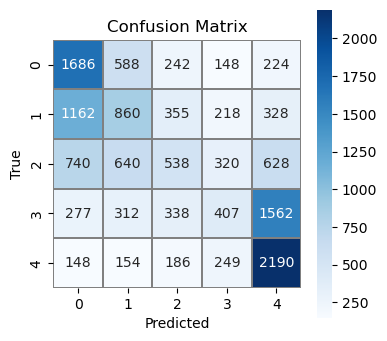

In [26]:
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

def eval(y_true, y_pred):
  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred, average='weighted')
  recall = recall_score(y_true, y_pred, average='weighted')
  f1 = f1_score(y_true, y_pred, average='weighted')
  cm = confusion_matrix(y_true, y_pred)

  print("Accuracy: {:.2f}".format(accuracy))
  print("Precision: {:.2f}".format(precision))
  print("Recall: {:.2f}".format(recall))
  print("F1 Score: {:.2f}".format(f1))

  plt.figure(figsize=(4, 4))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", square=True, linewidths=0.01, linecolor="gray")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.title("Confusion Matrix")
  plt.show()

eval(test_labels, test_predictions)

In [23]:
# torch.save(net, "./RNN_10_epochs.pt")

**Dataset Shift**

In [32]:
df = pd.read_csv('Reviews.csv')
# print(df.shape)
df = df
# print(df.shape)

df.head()

# print(df['HelpfulnessNumerator'].unique())
# print(df['HelpfulnessNumerator'].unique().shape)

shift_df_train = df[df['HelpfulnessNumerator'] == 0]
shift_df_test = df[df['HelpfulnessNumerator'] != 0]

shift_df_train['tokenized_text'] = shift_df_train['Text'].apply(word_tokenize)
shift_df_train['filtered_text'] = shift_df_train['tokenized_text'].apply(filter_words)
shift_all_reviews = shift_df_train['filtered_text'].tolist()
shift_df_test['tokenized_text'] = shift_df_test['Text'].apply(word_tokenize)
shift_df_test['filtered_text'] = shift_df_test['tokenized_text'].apply(filter_words)
shift_all_reviews_test = shift_df_test['filtered_text'].tolist()

/tmp/ipykernel_32676/2705420708.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shift_df_train['tokenized_text'] = shift_df_train['Text'].apply(word_tokenize)
/tmp/ipykernel_32676/2705420708.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shift_df_train['filtered_text'] = shift_df_train['tokenized_text'].apply(filter_words)
/tmp/ipykernel_32676/2705420708.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

In [33]:
# transform reviews into lists of numbers

print('for loops start')

e_rev = []
for review in shift_all_reviews:
  e = []
  for word in review:
    if word not in vocab_to_int.keys():
      e.append(0)
    else:
      e.append(vocab_to_int[word])
  e_rev.append(e)

# transform reviews into lists of numbers
e_rev_test = []
for review in shift_all_reviews_test:
  e = []
  for word in review:
    if word not in vocab_to_int.keys():
      e.append(0)
    else:
      e.append(vocab_to_int[word])
  e_rev_test.append(e)

print('finished first for loops')

length = 300
shift_feats = np.zeros((len(e_rev), length), dtype=int)
shift_feats_test = np.zeros((len(e_rev_test), length), dtype=int)

for i, rev in enumerate(e_rev):
  if len(rev) > length:
    shift_feats[i,:] = np.array(rev[:length])
  else:
    for j in range(len(rev)):
      shift_feats[i,j] = rev[j]

for i, rev in enumerate(e_rev_test):
  if len(rev) > length:
    shift_feats_test[i,:] = np.array(rev[:length])
  else:
    for j in range(len(rev)):
      shift_feats_test[i,j] = rev[j]
    
print('finished second for loops')

shift_labels = shift_df_train['Score'].array
shift_labels_test = shift_df_test['Score'].array

for loops start
finished first for loops
finished second for loops


In [34]:
# correct for variable names and run for each dataset (helpful 0 vs nonzero)

data = np.column_stack((shift_feats, shift_labels))
data = data.astype(float)
transform = transforms.Compose([transforms.ToTensor()])

data = transform(data)
data = torch.squeeze(data, dim=0)

feats0 = data[:, :-1]
labels = data[:, -1]
labels = F.one_hot(labels.to(torch.int64), num_classes = 6)

labels0 = labels[:, 1:]

# correct for variable names and run for each dataset (helpful 0 vs nonzero)

data = np.column_stack((shift_feats_test, shift_labels_test))
data = data.astype(float)
transform = transforms.Compose([transforms.ToTensor()])

data = transform(data)
data = torch.squeeze(data, dim=0)

feats1 = data[:, :-1]
labels = data[:, -1]
labels = F.one_hot(labels.to(torch.int64), num_classes = 6)

labels1 = labels[:, 1:]

In [44]:
# Dataset

print(feats0.size())
print(feats1.size())

test_dataset_0 = TensorDataset(torch.LongTensor(feats0.numpy()), torch.LongTensor(labels0.numpy()))
test_dataset_1 = TensorDataset(torch.LongTensor(feats1.numpy()), torch.LongTensor(labels1.numpy()))


batch_size_0 = 2081
batch_size_1 = 727

test_dataloader_0 = DataLoader(test_dataset_0, batch_size=batch_size_0, shuffle=False)
test_dataloader_1 = DataLoader(test_dataset_1, batch_size=batch_size_1, shuffle=False)

torch.Size([303826, 300])
torch.Size([264628, 300])


In [49]:
net = torch.load('./RNN_10_epochs.pt')

test_losses = [] # track loss
num_correct = 0
test_predictions = np.array([])
test_labels = np.array([])

# init hidden state
h = net.init_hidden(batch_size)

net.eval()
# iterate over test data
for inputs, labels in test_dataloader_0:

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    h = tuple([each.data for each in h])

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()


    output, h = net(inputs, h)

    # calculate loss
    # test_loss = criterion(output.squeeze(), labels.float().squeeze()) # for binary
    test_loss = criterion(output.squeeze(), labels.float())

    test_losses.append(test_loss.item())

    # convert output probabilities to predicted class (0 or 1)
    # pred = torch.round(output.squeeze())  # rounds to the nearest integer for binary

    # compare predictions to true label
    correct_tensor = output.eq(labels.float().view_as(output))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)

    # store predictions for post-processing
    predicted = torch.max(output, 1).indices
    test_predictions = np.concatenate((test_predictions, predicted.detach().cpu().numpy()))
    test_labels = np.concatenate((test_labels, (torch.max(labels,dim=1).indices).cpu().numpy()))


# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
print(test_predictions)
print(test_labels)
print(num_correct)
num_correct = num_correct / 5
print(len(test_dataloader.dataset))
test_acc = num_correct/len(test_dataloader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

RuntimeError: Expected hidden[0] size (3, 2081, 350), got [3, 500, 350]

In [ ]:
eval(test_labels, test_predictions)

In [ ]:
net = torch.load('./RNN_10_epochs.pt')

test_losses = [] # track loss
num_correct = 0
test_predictions = np.array([])
test_labels = np.array([])

# init hidden state
h = net.init_hidden(batch_size)

net.eval()
# iterate over test data
for inputs, labels in test_dataloader_1:

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    h = tuple([each.data for each in h])

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()


    output, h = net(inputs, h)

    # calculate loss
    # test_loss = criterion(output.squeeze(), labels.float().squeeze()) # for binary
    test_loss = criterion(output.squeeze(), labels.float())

    test_losses.append(test_loss.item())

    # convert output probabilities to predicted class (0 or 1)
    # pred = torch.round(output.squeeze())  # rounds to the nearest integer for binary

    # compare predictions to true label
    correct_tensor = output.eq(labels.float().view_as(output))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)

    # store predictions for post-processing
    predicted = torch.max(output, 1).indices
    test_predictions = np.concatenate((test_predictions, predicted.detach().cpu().numpy()))
    test_labels = np.concatenate((test_labels, (torch.max(labels,dim=1).indices).cpu().numpy()))


# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
print(test_predictions)
print(test_labels)
print(num_correct)
num_correct = num_correct / 5
print(len(test_dataloader.dataset))
test_acc = num_correct/len(test_dataloader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

In [ ]:
eval(test_labels, test_predictions)